<div align="center"> 

# **"TTE Conversion from R to Python (TTE-v1)"**

</div>

<div align="justify"> 

### **Python Library Imports**

</div>

In [8]:
import os
import joblib
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from dataclasses import dataclass
from typing import Optional, List, Dict, Union

<div align="justify"> 

### <span style="color:rgb(255, 123, 0);">**Step 1: Define the Estimand**</span>
Specify the type of effect you want to estimate, such as ***intention-to-treat (ITT)*** or ***per-protocol (PP)***. This determines how treatment adherence is handled in the analysis.

</div>

<div align="justify"> 

##### <span style="color:rgb(0, 207, 121);">**"Why are we creating folders for *'trial_pp'* and *'trial_itt'*?"**</span>
The analysis involves saving results or intermediate files specific to each estimand (Per-Protocol (PP) and Intention-to-Treat (ITT)). These folders are likely used to organize and store **outputs generated during the analysis process**. Here's a brief breakdown:

1. **Organizing Results:** Different estimands (PP and ITT) may produce different results or outputs. Creating separate folders helps keep the results organized and avoids mixing files.
2. **Reproducibility:** Saving intermediate files (e.g., datasets, models, or plots) allows you to revisit or reproduce the analysis later without rerunning everything.
3. **Comparison:** By storing results for PP and ITT separately, you can easily compare the outcomes of the two estimands.
4. **Scalability:** If the analysis involves multiple steps or iterations, having dedicated folders makes it easier to manage and scale the workflow.

</div>

In [9]:
# Step 1: Specify the estimand
trial_pp = {"estimand": "PP"}  # Per-protocol
trial_itt = {"estimand": "ITT"}  # Intention-to-treat

# Step 2: Define the base directory as "./Dataset"
base_dir = "../Datasets"

# Step 3: Create directories to save files
trial_pp_dir = os.path.join(base_dir, "trial_pp")
trial_itt_dir = os.path.join(base_dir, "trial_itt")

# Create the directories (including the base directory if it doesn't exist)
os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

# Print the paths for verification
print(f"Per-Protocol (PP) directory: {trial_pp_dir}")
print(f"Intention-to-Treat (ITT) directory: {trial_itt_dir}")

Per-Protocol (PP) directory: ../Datasets\trial_pp
Intention-to-Treat (ITT) directory: ../Datasets\trial_itt


<div align="justify"> 

### <span style="color:rgb(255, 123, 0);">**Step 2: Prepare Observational Data**</span>
Ensure your dataset includes columns for treatment, outcomes, and eligibility criteria. This step is crucial for aligning your observational data with the hypothetical RCT you are emulating.

##### <span style="color:rgb(0, 207, 121);">**Code Snippet Process Breakdown:**</span>

1. Here we simply load and display the first five rows of the dataset from the 'data_censored.csv' file to verify if it has been loaded correctly. 
2. Given the setData() function, we define an object named **'trial'** (a dictionary) to associate and assign with a dataset and its specific columns.

    The function takes the following arguments: </br>
   - **trial:** The dictionary to be configured. </br>
   - **data:** The dataset (a pandas DataFrame). </br>
   - **id_col:** The column name for the unique identifier (e.g., "id"). </br>
   - **period_col:** The column name for the time period (e.g., "period"). </br>
   - **treatment_col:** The column name for the treatment indicator (e.g., "treatment"). </br>
   - **outcome_col:** The column name for the outcome variable (e.g., "outcome"). </br>
   - **eligible_col:** The column name for the eligibility indicator (e.g., "eligible").  </br>

3. We then configure the **'trial_pp'** by creating an empty dictionary out of it that shall represent the Per-Protocol (PP) trial. The set_data function is called to configure trial_pp with the dataset (data_censored) and the specified columns (id, period, treatment, outcome, eligible).
4. Then configure the **'trial_itt'** by creating an empty dictionary out of it that shall represent the Intention-To-Treat (ITT) trial. The set_data function is called to configure trial_itt with the same dataset and columns as trial_pp.
5. We print the configured 'trial_pp' and 'trial_itt' objects to verify the content of these dictionaries.

</div>

In [10]:
# Step 1: Load the dataset from "../Dataset/data_censored.csv"
dataset_path = "../Datasets/data_censored.csv"
data_censored = pd.read_csv(dataset_path)

# Display the first few rows of the dataset
print("Loaded Dataset:")
print(data_censored.head())

# Step 2: Define a function to set data for analysis
def set_data(trial, data, id_col, period_col, treatment_col, outcome_col, eligible_col):
    """
    Configures the trial object with the specified dataset and columns.
    """
    trial['data'] = data
    trial['id'] = id_col
    trial['period'] = period_col
    trial['treatment'] = treatment_col
    trial['outcome'] = outcome_col
    trial['eligible'] = eligible_col
    return trial

# Step 3: Configure trial_pp (Per-Protocol)
trial_pp = {}
trial_pp = set_data(
    trial_pp,
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible"
)

# Step 4: Configure trial_itt (Intention-to-Treat)
trial_itt = {}
trial_itt = set_data(
    trial_itt,
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible"
)

# Step 5: Print the configured trial objects
print("\nPer-Protocol (PP) Trial:")
print(trial_pp)

print("\nIntention-to-Treat (ITT) Trial:")
print(trial_itt)

Loaded Dataset:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  

Per-Protocol (PP) Trial:
{'data':      id  period  treatment  x1        x2  x3        x4  age     age_s  \
0     1       0          1   1  1.146148   0  0.734203   36  0.083333   
1     1       1          1   1  0.002200   0  0.734203   37  0.166667   
2     1       2          1   0 -0.481762   0  0.734203   38  0.250000   
3     1       3          1   0  

<div align="justify"> 

##### <span style="color:rgb(0, 207, 121);">**Miscellaneuous: Visualizing the Initialized Dictionaries**</span>

I wanted to see for myself what the current dictionaries look like on a bar graph of the properties: treatment, outcome, elligible, and period. 

</div>

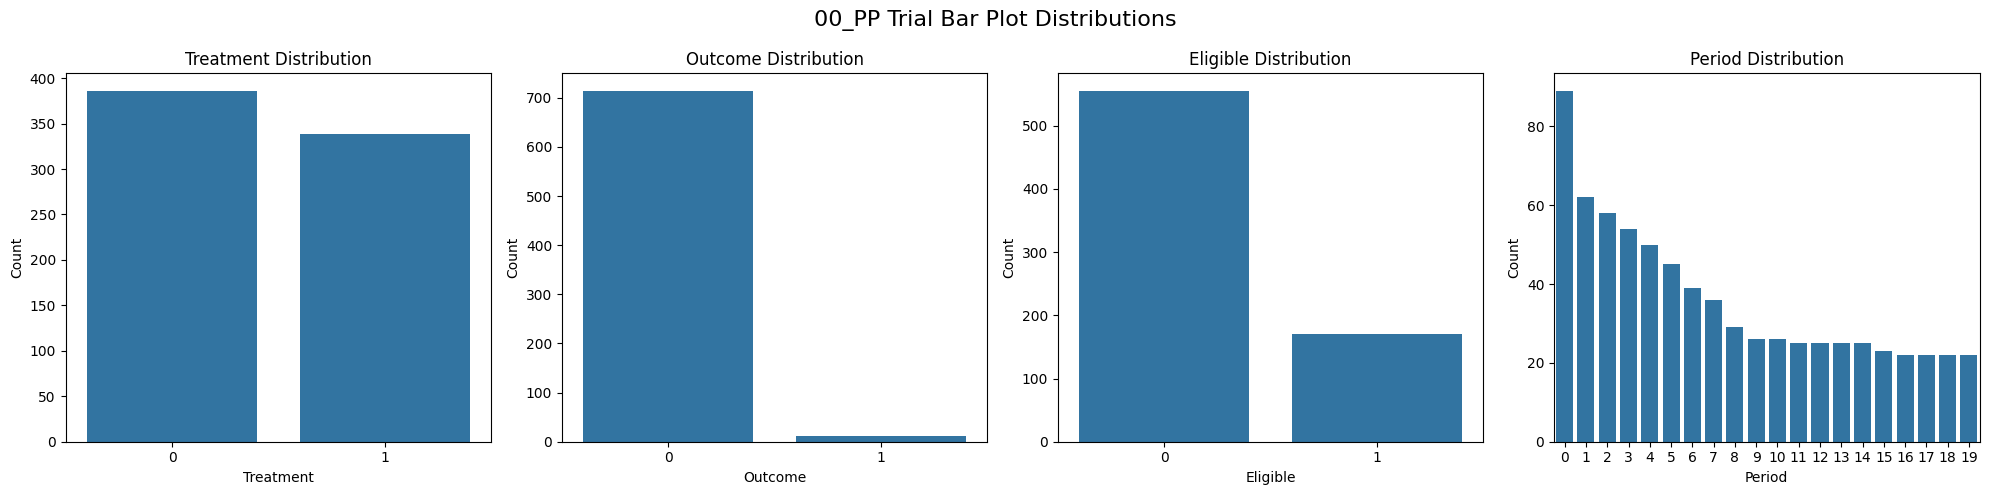

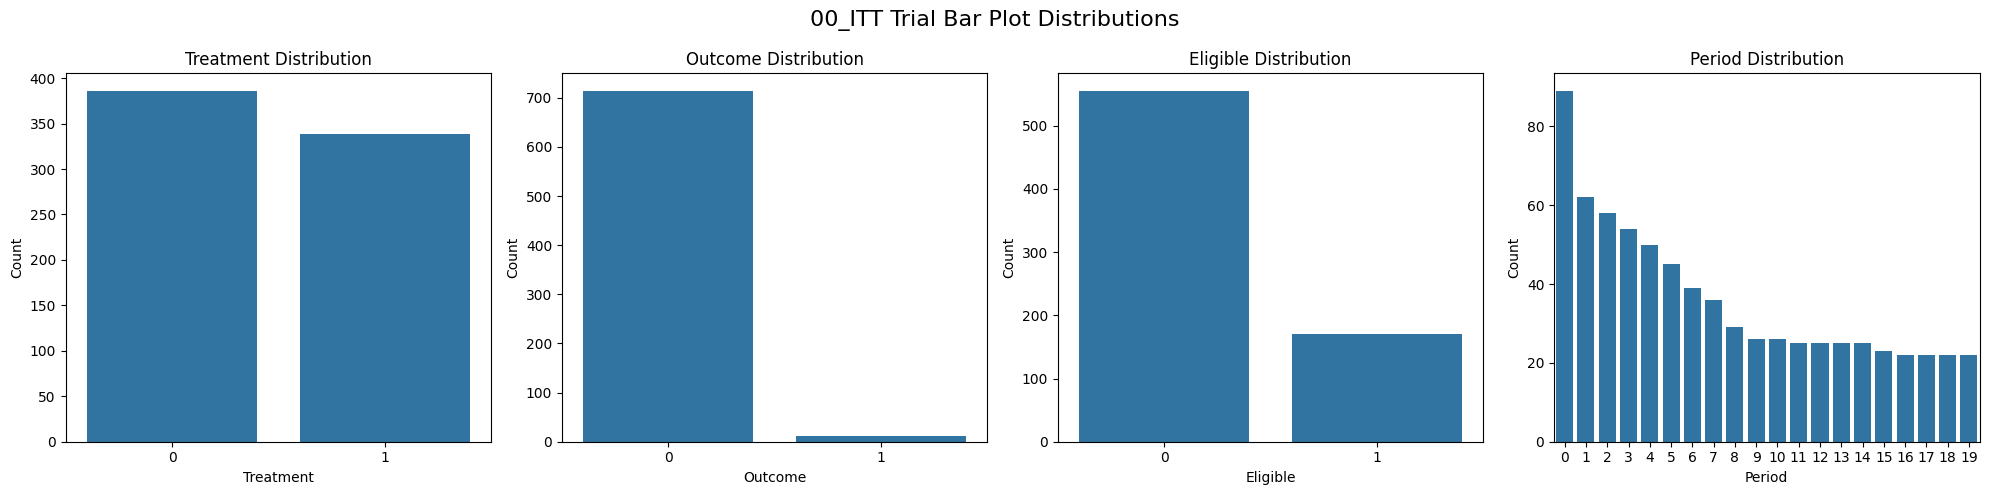

In [11]:
# Define the custom color
# custom_pink = (255/255, 0/255, 149/255)  # PINK
# custom_green = (0/255, 207/255, 121/255)  # GREEN (too bright, not good on white bg)

# Function to plot distributions
def plot_distributions(trial, title, save_dir):
    data = trial['data']
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns
    fig.suptitle(title, fontsize=16)

    # Plot treatment distribution
    sns.countplot(x=trial['treatment'], data=data, ax=axes[0])
    axes[0].set_title("Treatment Distribution")
    axes[0].set_xlabel("Treatment")
    axes[0].set_ylabel("Count")

    # Plot outcome distribution
    sns.countplot(x=trial['outcome'], data=data, ax=axes[1])
    axes[1].set_title("Outcome Distribution")
    axes[1].set_xlabel("Outcome")
    axes[1].set_ylabel("Count")

    # Plot eligible distribution
    sns.countplot(x=trial['eligible'], data=data, ax=axes[2])
    axes[2].set_title("Eligible Distribution")
    axes[2].set_xlabel("Eligible")
    axes[2].set_ylabel("Count")

    # Plot period distribution
    sns.countplot(x=trial['period'], data=data, ax=axes[3])
    axes[3].set_title("Period Distribution")
    axes[3].set_xlabel("Period")
    axes[3].set_ylabel("Count")

    plt.tight_layout()

    # Save the figure
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  # Create the directory if it doesn't exist
    save_path = os.path.join(save_dir, f"{title.replace(' ', '_')}.png")
    plt.savefig(save_path, bbox_inches='tight')  # Save the plot

    plt.show()

# Visualize Per-Protocol (PP) Trial
plot_distributions(trial_pp, "00_PP Trial Bar Plot Distributions", "../Datasets/trial_pp")

# Visualize Intention-to-Treat (ITT) Trial
plot_distributions(trial_itt, "00_ITT Trial Bar Plot Distributions", "../Datasets/trial_itt")

<div align="justify"> 

Right now, **they look the same and why is that?** Both 'trial_pp' and 'trial_itt' are both using the same dataset which is 'data_censored.csv'. As of right now, we currently have no data filtering or any modification applied to the dataset to be able to have a distiction between the two. **We are simply using the raw data as-is.**


### <span style="color:rgb(255, 123, 0);">**Step 3: Address Censoring Mechanisms**</span>
Use **Inverse Probability of Censoring Weights (IPCW)** to adjust for biases due to *treatment switching* and *informative censoring*. This involves fitting separate models to calculate these weights.

##### <span style="color:rgb(0, 207, 121);">**"First of all, what is 'Informative Censoring'?"**</span>
Informative censoring occurs **when the reason for censoring is related to the outcome of interest**. This can lead to biased estimates if not properly addressed. This refers to particularly in survival analysis, where participants are lost to follow-up or censored for reasons related to their treatment or outcome. 

For example, a student dropping out of a study. This type of censoring can introduce bias into the results, as the characteristics of those who drop out may differ significantly from those who remain in the study. The key points for Informative Censoring are as follows.

1. **Definition:** Informative censoring occurs when the reasons for participants being censored are related to their likelihood of experiencing the event of interest (e.g., disease progression or death). For example, in a clinical trial for cancer treatment, patients may drop out because their condition worsens or they experience severe side effects, which could skew the results if not properly accounted for25.

2. **Impact on Analysis:** When informative censoring is present, the remaining participants may not represent the original population adequately. For instance, if sicker patients are more likely to be censored, the estimated treatment effects could be overestimated for one group and underestimated for another23.

3. **Comparison with Non-informative Censoring:** In contrast, non-informative censoring occurs when participants drop out for reasons unrelated to their treatment or outcomes. In this case, the censored data can still provide valid estimates of treatment effects2.

4. **Addressing Informative Censoring:** Several methods exist to mitigate the effects of informative censoring, including:
     - Imputation techniques to handle missing data.
     - Sensitivity analyses to explore how different assumptions about missing data affect results.
     - Using dropout events as endpoints in the analysis.

Informative censoring can bias results in studies, particularly when analyzing progression-free survival in clinical trials. To address this, analyses should consider factors such as **rates of treatment discontinuation due to toxicity**, **the potential for imbalances in censoring between treatment arms**, and **the relationship between censoring and the risk of the event of interest**. Recognizing and accounting for these factors can help to reduce bias and provide a more accurate understanding of treatment effects

##### <span style="color:rgb(0, 207, 121);">**"What are Inverse Probability of Censoring Weights (IPCW)?"**</span>
IPCW is a method to fix bias caused by censoring in studies. It gives more weight to people who stay in the study and are similar to those who dropped out, ensuring the results are accurate. How does it work?

1. **Estimating Censoring Probabilities:** Use the inverse of these probabilities as weights. These weights show how likely someone is to stay in the study.

2. **Calculating Weights:** Use the inverse of these probabilities as weights. These weights show how likely someone is to stay in the study.

3. **Weighted Analysis:** Use the weights to give more importance to people who stayed in the study and are similar to those who dropped out. This corrects for bias.

*The following is the Application of IPCW*

- **Treatment Switching:** When patients switch treatments, IPCW adjusts for the bias this creates.

- **Survival Analysis:** IPCW helps estimate treatment effects more accurately by accounting for censoring.

**IPCW addresses Informative Censoring by estimating the probability of being censored at each time point and using the inverse of these probabilities as weights**. These weights give more importance to participants who remain in the study and have similar characteristics to those who were censored, helping to provide unbiased estimates of treatment effects. In short, IPCW corrects bias by estimating how likely people are to drop out and using weights to make sure the analysis is fair and accurate.

##### <span style="color:rgb(0, 207, 121);">**"How Are IPCW Estimated?"**</span>
To estimate IPCW, researchers typically fit **time-to-censoring event models**. These models predict the likelihood of censoring at each time point. The inverse of these probabilities is used as weights to adjust for bias.

*The following are steps involved in this process*

1. **Data Collection:** Gather information on factors (e.g., health status, treatment history) at the start of the study and over time until an event (e.g., treatment switch, death, or study end) occurs.

2. **Modeling Censoring Probabilities:** Build a model (e.g., logistic regression or survival model) to predict the chance of being censored at each time point.

3. **Calculating Weights:** Use the inverse of the predicted censoring probabilities as weights. These weights reflect the likelihood of staying in the study (or not switching treatments) over time.

4. **Weighted Analysis:** Use the weights to adjust for bias in the analysis. This ensures that participants who remain in the study (or stay on their original treatment) are properly represented.

For example, in scenarios involving treatment switching, a "switching model" is developed to estimate these weights, which are then used in an "outcome model" to estimate treatment effects adjusted for switching.

##### <span style="color:rgb(0, 207, 121);">**"Well, how does this apply to TTE then?"**</span>
In this scenario, two sets of models ('trial_pp' & 'trial_it') are fit to address two types of censoring mechanisms:

1. **Censoring due to deviation from assigned treatment:** This occurs when participants switch treatments, which can affect the outcome if not properly adjusted for2.
2. **Other informative censoring:** This includes any other reasons for censoring that might be related to the outcome, such as loss to follow-up or withdrawal due to health issues.

IPCW is particularly useful in scenarios where treatment switching occurs, as it helps adjust for biases in survival analysis. Here's how IPCW is applied in such contexts:

1. **Addressing Treatment Switching:** When patients switch treatments, their data is artificially censored, leading to biased results. IPCW adjusts for this by estimating the likelihood of staying on the original treatment.

2. **Estimating Weights:** A model (e.g., logistic regression) predicts the probability of switching treatments. The inverse of these probabilities is used as weights.

3. **Weighted Analysis:** These weights are applied to the analysis to ensure that participants who stayed on their original treatment (but are similar to those who switched) are properly accounted for.

4. **Real-World Applications:** IPCW is commonly used in clinical trials, especially in cancer studies, where treatment switching is frequent. It helps provide more accurate estimates of treatment effects by accounting for censoring.

By using IPCW, we can better estimate survival outcomes and treatment effects in complex scenarios, ensuring more reliable conclusions about treatment efficacy.

</div>

<div align="justify"> 

#### <span style="color:rgb(255, 123, 0);">***Step 3.1: Treatment Switching***</span>
This section essentially describes how to handle censoring due to treatment switching using statistical models. Here's a simplified explanation:

1. **Modeling Treatment Switching:** Two separate models are developed to estimate the probability of receiving treatment in the current period. One model is for patients who received treatment (treatment = 1) in the previous period, and another for those who did not (treatment = 0).

2. **Stabilized Weights:** These models are used to calculate stabilized weights, which help adjust for biases due to treatment switching. Stabilized weights are derived by fitting both numerator and denominator models.

3. **Optional Arguments:** There are options to include or exclude certain observations from the treatment models. This is useful when patients cannot deviate from their assigned treatment in a particular period, ensuring that the analysis only considers relevant data.

##### <span style="color:rgb(0, 207, 121);">**Code Snippet Process Breakdown:**</span>
1. **Define the Treatment Weight Models:** Fit separate **logistic regression models** for patients who had treatment = 1 and treatment = 0 in the previous period. Use stabilized weights by fitting numerator and denominator models.

2. **Handle Optional Columns:** Allow for columns to include/exclude observations from the treatment models.

3. **Save Model Outputs:** Save the fitted models to a specified directory.

<span style="color:rgb(114, 114, 114);">**TEST:** Have a cluster or simply just a visualization of patients who had treatment and those who didn't. Try to distinguish them based on their other attributes.</span>

</div>

In [12]:
# Define file paths
data_path = "../Datasets/data_censored.csv"
trial_pp_dir = "../Datasets/trial_pp"
tte_models_dir = "../TTE Models"  # Directory for saving models

# Ensure directories exist
os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(tte_models_dir, exist_ok=True)

# Load the dataset
data_censored = pd.read_csv(data_path)

# Define a function to fit logistic regression models
def fit_logit_model(data, formula, save_path=None):
    """
    Fit a logistic regression model using the specified formula.
    
    Args:
        data: DataFrame containing the data
        formula: String formula like "~ age + x1" (target is assumed to be 'treatment')
        save_path: Path to save the model (optional)
    Returns:
        Fitted LogisticRegression model
    """
    features = formula.replace("~", "").strip().split(" + ")
    X = data[features]  # Features
    y = data['treatment']  # Target (assuming 'treatment' is the column)

    model = LogisticRegression(max_iter=1000)  # Increased max_iter for convergence
    model.fit(X, y)

    if save_path:
        joblib.dump(model, save_path)

    return model

# Define the set_switch_weight_model function
def set_switch_weight_model(data, numerator, denominator, model_fitter, save_dir, tte_models_dir):
    """
    Fit numerator and denominator models for stabilized weights and calculate weights.
    
    Args:
        data: DataFrame with the dataset
        numerator: Formula for numerator model (e.g., "~ age")
        denominator: Formula for denominator model (e.g., "~ age + x1 + x3")
        model_fitter: Function to fit the models
        save_dir: Directory to save the processed data
        tte_models_dir: Directory to save the models
    Returns:
        DataFrame with added 'weights', 'num_probs', and 'denom_probs' columns
    """
    # Fit numerator model
    numerator_model = model_fitter(
        data, numerator, save_path=os.path.join(tte_models_dir, "numerator_model.pkl")
    )

    # Fit denominator model
    denominator_model = model_fitter(
        data, denominator, save_path=os.path.join(tte_models_dir, "denominator_model.pkl")
    )

    # Calculate stabilized weights and probabilities
    def calculate_stabilized_weights_and_probs(data, num_model, denom_model, num_formula, denom_formula):
        num_features = num_formula.replace("~", "").strip().split(" + ")
        denom_features = denom_formula.replace("~", "").strip().split(" + ")

        num_probs = num_model.predict_proba(data[num_features])[:, 1]
        denom_probs = denom_model.predict_proba(data[denom_features])[:, 1]
        weights = np.where(denom_probs > 0, num_probs / denom_probs, 1.0)
        return weights, num_probs, denom_probs

    # Add weights and probabilities to the dataset
    data_with_weights = data.copy()
    weights, num_probs, denom_probs = calculate_stabilized_weights_and_probs(
        data_with_weights, numerator_model, denominator_model, numerator, denominator
    )
    data_with_weights['weights'] = weights
    data_with_weights['num_probs'] = num_probs
    data_with_weights['denom_probs'] = denom_probs

    # Save the dataset with weights
    output_path = os.path.join(save_dir, "PPdata_with_weights.csv")
    data_with_weights.to_csv(output_path, index=False)
    print(f"Data with weights saved to {output_path}")

    return data_with_weights

# Define the model_fitter function (logistic regression)
def stats_glm_logit(save_path=None):
    """
    Wrapper function to fit logistic regression models.
    """
    def fit(data, formula, save_path=save_path):
        return fit_logit_model(data, formula, save_path)
    return fit

# Apply set_switch_weight_model to trial_pp only
trial_pp = set_switch_weight_model(
    data_censored,
    numerator="~ age",
    denominator="~ age + x1 + x3",
    model_fitter=stats_glm_logit(),
    save_dir=trial_pp_dir,
    tte_models_dir=tte_models_dir
)

# Do NOT apply set_switch_weight_model to trial_itt (see explanation below)
trial_itt = data_censored.copy()  # For ITT, we just use the original data for now

print("Switch weight models fitted and weights calculated for trial_pp!")

Data with weights saved to ../Datasets/trial_pp\PPdata_with_weights.csv
Switch weight models fitted and weights calculated for trial_pp!


<div align="justify"> 

##### <span style="color:rgb(0, 207, 121);">**Miscellanous: Data Visualization of Weights and Models**</span>

This visualization is tailored to the outputs of set_switch_weight_model applied to trial_pp, which generates stabilized weights and logistic regression probabilities for treatment switching adjustments. The plots are designed to provide insight into the stabilized weights and the logistic regression models (numerator and denominator) used to adjust for treatment switching in the PP analysis. Here’s why each plot is included:

1. **Distribution of Stabilized Weights (Histogram with KDE):** To examine the spread, central tendency, and variability of the weights (weights = num_probs / denom_probs). Stabilized weights should ideally be centered around 1 with moderate variation—extreme values (very high or very low) could indicate model misspecification or instability. 
   - **Why:** In inverse probability weighting (IPW), weights adjust for confounding or censoring (here, treatment switching). Checking their distribution ensures they’re reasonable and usable in downstream analyses like marginal structural models (MSMs).

2. **Numerator vs. Denominator Probabilities (Scatter Plot):** To compare the predicted probabilities from the numerator model (~ age) and denominator model (~ age + x1 + x3), with points colored by treatment. This shows how the simpler (numerator) and more complex (denominator) models differ in estimating treatment probability. 
   - **Why:** Stabilized weights are the ratio of these probabilities. Visualizing their relationship helps diagnose whether the stabilization works (e.g., numerator probs are less variable than denominator probs) and how treatment groups differ.

3. **Weights vs. Treatment (Box Plot):** To assess how weights vary between treatment groups (treatment = 0 vs. 1). This checks if the weights systematically differ by treatment, which is expected since they adjust for switching behavior. 
   - **Why:** In PP analysis, weights correct for deviations from the protocol (e.g., switching off treatment). Differences by treatment group validate that the weights are capturing this dynamic.

4. **Logistic Probabilities vs. Age (Scatter Plot):** To visualize how the numerator and denominator probabilities depend on age, a key covariate in both models. Separate lines/colors distinguish the two models. 
   - **Why:** This shows the logistic regression fits in action—how age influences the probability of treatment, and how adding x1 and x3 in the denominator changes the predictions. It’s a diagnostic for model fit and covariate effect.

</div>

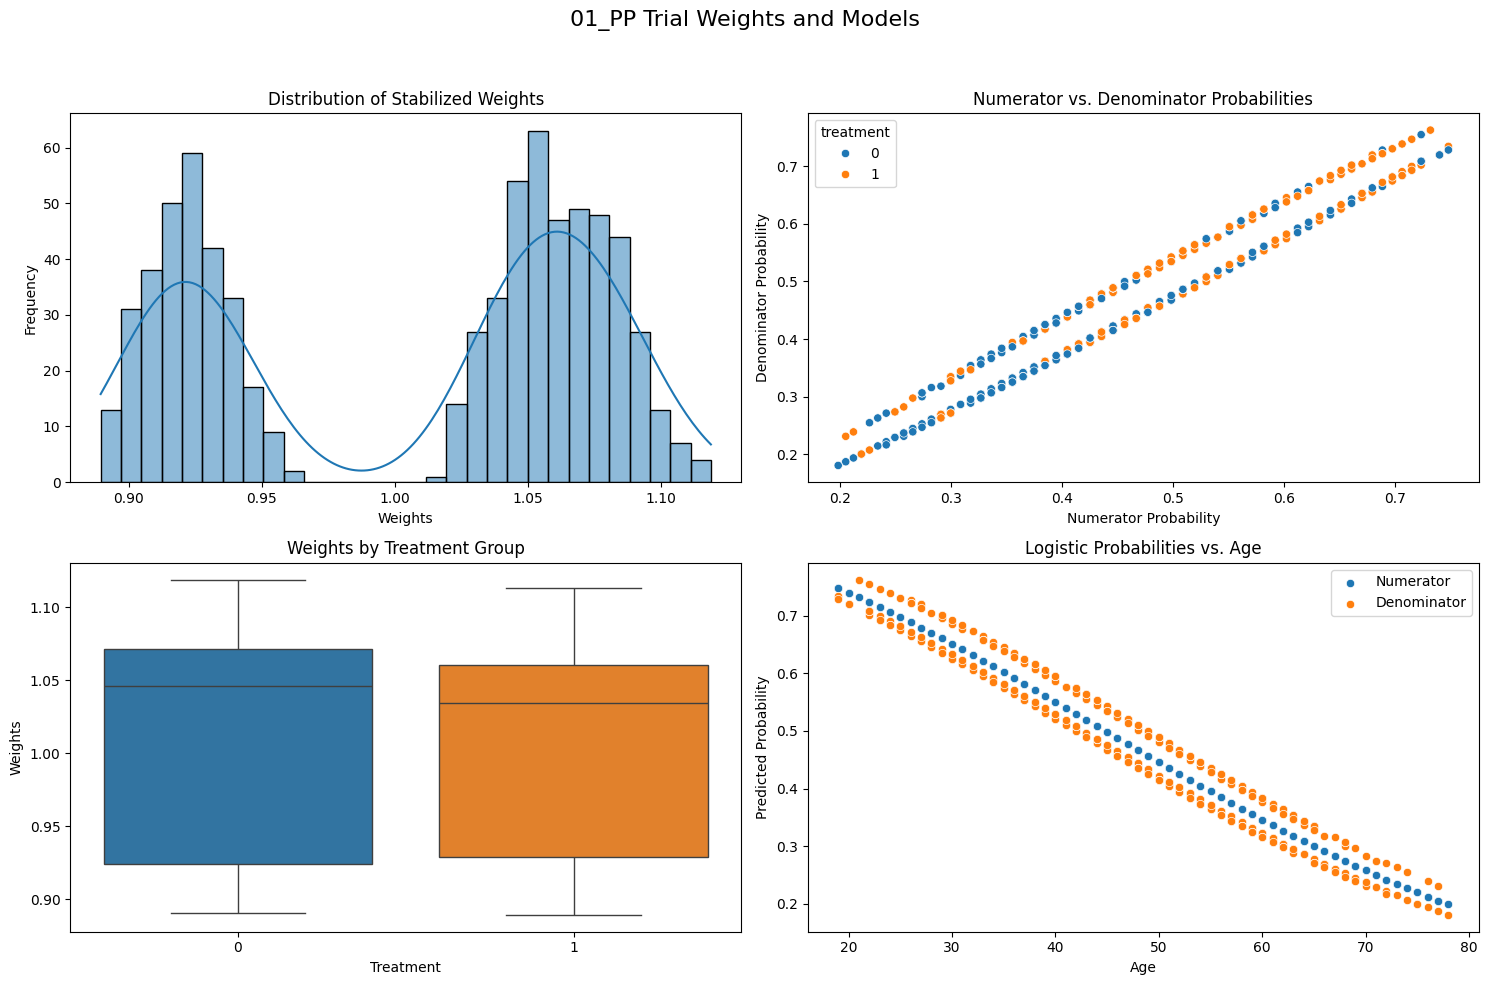

In [13]:
# Visualization function without custom colors
def visualize_weights_and_models(data, title, save_dir):
    """
    Visualize weights, numerator/denominator probabilities, and logistic fits.
    
    Args:
        data: DataFrame with 'weights', 'num_probs', 'denom_probs', 'treatment', 'age'
        title: Title for the visualization
        save_dir: Directory to save the plot
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)

    # Plot 1: Distribution of weights
    sns.histplot(data['weights'], bins=30, kde=True, ax=axes[0, 0])
    axes[0, 0].set_title("Distribution of Stabilized Weights")
    axes[0, 0].set_xlabel("Weights")
    axes[0, 0].set_ylabel("Frequency")

    # Plot 2: Numerator vs. Denominator Probabilities
    sns.scatterplot(x=data['num_probs'], y=data['denom_probs'], hue=data['treatment'], ax=axes[0, 1])
    axes[0, 1].set_title("Numerator vs. Denominator Probabilities")
    axes[0, 1].set_xlabel("Numerator Probability")
    axes[0, 1].set_ylabel("Denominator Probability")

    # Plot 3: Weights vs. Treatment
    sns.boxplot(x=data['treatment'], y=data['weights'], hue=data['treatment'], ax=axes[1, 0], legend=False)
    axes[1, 0].set_title("Weights by Treatment Group")
    axes[1, 0].set_xlabel("Treatment")
    axes[1, 0].set_ylabel("Weights")

    # Plot 4: Logistic Fit (Probabilities vs. Age)
    sns.scatterplot(x=data['age'], y=data['num_probs'], label='Numerator', ax=axes[1, 1])
    sns.scatterplot(x=data['age'], y=data['denom_probs'], label='Denominator', ax=axes[1, 1])
    axes[1, 1].set_title("Logistic Probabilities vs. Age")
    axes[1, 1].set_xlabel("Age")
    axes[1, 1].set_ylabel("Predicted Probability")
    axes[1, 1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for suptitle
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, f"{title.replace(' ', '_')}_Visualization.png"))
    plt.show()

# Visualize results for trial_pp
visualize_weights_and_models(trial_pp, "01_PP Trial Weights and Models", trial_pp_dir)

<div align="justify"> 

##### <span style="color:rgb(0, 207, 121);">**Miscellanous: Visualization of Trial_PP After Treatment Switching**</span>

Let's visualize Trial_PP from how we visualized it earlier before we applied Treatment Switching (Unweighted) to after we applied Treatment Switching (Weighted) in which we simulate an ideal scenarion in which treatent were not discontinued.

</div>

Plot saved to ../Datasets/trial_pp\02_Trial_PP_After_Treatment_Switching.png


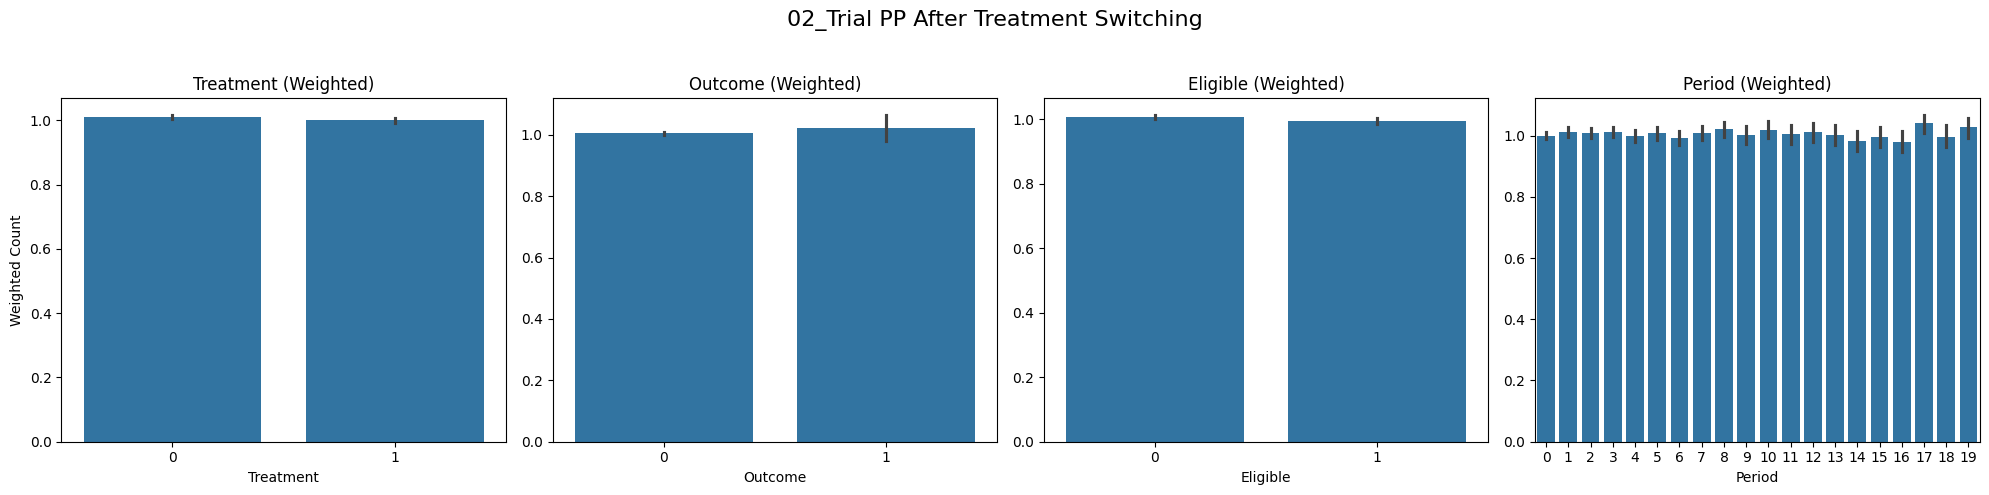

In [14]:
# File paths
data_censored_path = "../Datasets/data_censored.csv"
trial_pp_weights_path = "../Datasets/trial_pp/PPdata_with_weights.csv"
save_dir = "../Datasets/trial_pp"

# Load the datasets
data_censored = pd.read_csv(data_censored_path)
trial_pp = pd.read_csv(trial_pp_weights_path)

# Function to plot unweighted (before) vs weighted (after) distributions
def plot_before_after_distributions(after_data, title, save_dir):
    """
    Plot bar graphs comparing distributions before and after treatment switching.
    
    Args:
        before_data: DataFrame with original unweighted data (data_censored)
        after_data: DataFrame with weighted data (PPdata_with_weights)
        title: Title for the plot
        save_dir: Directory to save the plot
    """
    # Ensure save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Set up the figure with 1 row and 4 columns (variables)
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(title, fontsize=16)

    # Variables to plot
    variables = ['treatment', 'outcome', 'eligible', 'period']

    for i, var in enumerate(variables):
        # # Before (Unweighted) distribution - raw counts
        # sns.countplot(x=var, data=before_data, ax=axes[0, i])
        # axes[0, i].set_title(f"{var.capitalize()} (Unweighted)")
        # axes[0, i].set_xlabel(var.capitalize())
        # if i == 0:
        #     axes[0, i].set_ylabel("Count")
        # else:
        #     axes[0, i].set_ylabel("")

        # After (Weighted) distribution - using weights
        weighted_counts = after_data.groupby(var)['weights'].sum().reset_index()
        # print(f"{var}: {weighted_counts}")
        sns.barplot(x=var, y='weights', data=after_data, ax=axes[i])  
        axes[i].set_title(f"{var.capitalize()} (Weighted)")
        axes[i].set_xlabel(var.capitalize())
        if i == 0:
            axes[i].set_ylabel("Weighted Count")
        else:
            axes[i].set_ylabel("")

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle

    # Save the plot
    save_path = os.path.join(save_dir, f"{title.replace(' ', '_')}.png")
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Plot saved to {save_path}")

    # Display the plot
    plt.show()

# Plot distributions comparing before (data_censored) and after (trial_pp)
plot_before_after_distributions(
    trial_pp,
    "02_Trial PP After Treatment Switching",
    save_dir
)

<div align="justify"> 

**Treatment Switching Adjustment:** The weights are designed to correct for patients switching treatments in the PP analysis. If a patient switches, their weight might be adjusted to reflect their intended treatment group, balancing the analysis.

**Small Weighted Values:** The low weighted counts might indicate that the weights are fractions (e.g., probabilities or inverse probabilities of treatment), and the sum across all observations for a category reflects the effective sample size after adjustment. This is common in methods like Inverse Probability of Treatment Weighting (IPTW).

The weighted chart shows the adjusted distribution, which is more relevant for the PP analysis after accounting for treatment switching. The similarity in shapes suggests the weighting stabilizes the analysis without introducing bias, while the different scales reflect the mathematical adjustment of weights.

##### <span style="color:rgb(0, 207, 121);">**"Why is Treatmeant Switching only applied in Trial PP?"**</span>

Treatment switching adjustments, *implemented via set_switch_weight_model*, are applied only to trial_pp (Per-Protocol analysis) and **not to trial_itt** (Intention-to-Treat analysis) because this distinction is rooted in the **fundamental differences between the two causal estimands—Per-Protocol (PP) and Intention-to-Treat (ITT)**—and **how they handle treatment adherence in observational data or emulated trials**.

**Per-Protocol (PP) Estimand: *Focus on Adherence***

1. **Definition:** The PP estimand aims to estimate the effect of a treatment as if all patients adhered perfectly to their assigned treatment protocol throughout the study. It’s an idealized scenario asking, **“What would the treatment effect be if everyone followed the protocol?”**

2. **Treatment Switching:** In real-world data (like data_censored), patients often deviate from their assigned treatment—e.g., a patient assigned to treatment = 1 might switch to treatment = 0 (or vice versa) at some point. This switching introduces bias because the observed outcomes no longer reflect the intended treatment protocol.

3. **Adjustment Mechanism:** To emulate this “perfect adherence” scenario, PP analysis uses inverse probability of treatment switching weights (IPSW). These weights:
Censor patients at the time they switch (effectively removing their post-switch data from analysis).
Reweight the remaining data to represent a population that adheres to the protocol.

4. **Goal:** **To estimate a target trial where patients follow the protocol.** Switching is a form of censoring (informative, since it’s related to treatment and outcome), so IPSW adjusts for it using weights derived from the probability of staying on treatment.

Whereas...

**Intention-to-Treat (ITT) Estimand: *Focus on Assignment***

1. **Definition:** The ITT estimand estimates the effect of treatment assignment, regardless of whether patients adhere to it. It’s a pragmatic approach asking, **“What’s the effect of assigning treatment, given real-world adherence patterns?”**

2. **Treatment Switching:** In ITT, switching isn’t a bias to correct—it’s **part of the effect being measured**. Patients are analyzed based on their initial treatment assignment (e.g., treatment = 1 at baseline), even if they switch later. This reflects the practical impact of offering a treatment, including non-compliance.

3. **No Adjustment Needed:** Since ITT doesn’t aim to emulate perfect adherence, there’s no need to censor or reweight for treatment switching. Applying IPSW would distort the ITT estimand by artificially enforcing adherence, which contradicts its purpose.

4. **Goal:** To estimate the effect in a pragmatic trial where switching is part of the real-world scenario. No adjustment is made for switching, though other censoring (e.g., loss to follow-up) might still require weights (via set_censor_weight_model in the R code).

Simply put, we implement Treatment Switching for the Estimand Per-Protocol only because **we want to simulate an ideal scenario wherein the treatment protocol was followed all through out**. Meaning we would account the times in which treatment no longer occurs; making it so as if treatment were followed all the way through. With that said, we do not Implement Treatment Switching to Trial Intention-to-Treat because **we want to simulate a real-world scenario in which some treatments were discontinued** and the like. 

##### <span style="color:rgb(0, 207, 121);">**"Why not Trial ITT?"**</span>

If we applied 'set_switch_weight_model' to 'trial_itt', we would have following:

1. **Introduce Bias:** Weights would censor and reweight data to emulate adherence, contradicting ITT’s goal of measuring the assignment effect, including switching.

2. **Misalign with Estimand:** ITT would no longer reflect the pragmatic effect of treatment assignment, undermining its interpretability.

3. **Break Consistency:** The R code and causal inference literature (e.g., Hernán & Robins’ Causal Inference) treat switching adjustments as PP-specific.

#### <span style="color:rgb(255, 123, 0);">***Step 3.2: Informative Censoring***</span>

</div>

<div align="justify"> 

### <span style="color:rgb(255, 123, 0);">**Step 4: Expand Observational Data into Trial Datasets**</span>
Use predefined expansion options to create trial-specific datasets from your observational data. This step involves transforming your data into a format that mimics a sequence of RCTs.

</div>

<div align="justify"> 

### <span style="color:rgb(255, 123, 0);">**Step 5: Fit Marginal Structural Models (MSMs)**</span>
MSMs are used to estimate the causal effects of treatments. These models adjust for time-varying confounders and provide estimates of treatment effects over time.

</div>

<div align="justify"> 

### <span style="color:rgb(255, 123, 0);">**Step 6: Generate Predictions and Visualizations**</span>
Predict survival probabilities and cumulative incidences for different treatment scenarios. Visualize these predictions to illustrate how survival rates differ over time between treatment groups, facilitating meaningful inference about treatment effects.

</div>